In [1]:
import os
import glob
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme(style="whitegrid")

pd.options.display.max_rows = 200

os.chdir('/mnt/BioAdHoc/Groups/vd-ay/jreyna/projects/t1d-loop-catalog/')

outdir = 'results/hg38/finemapping/sgls_summary/'
os.makedirs(outdir, exist_ok=True)

#### Adding gene information

In [2]:
gencode_df = pd.read_table('results/refs/ensembl/gencode.v30.annotation.w_genetypes.bed', header=None,
                          names=['chrom', 'start', 'end', 'strand', 'type', 'geneid', 'genename', 'genetype'])
gencode_df = gencode_df.loc[gencode_df.type == 'gene'].drop('type', axis=1)
gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_65651/3756824197.py:4: SyntaxWarning: invalid escape sequence '\.'
  gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)


## Load all SGL Data


In [3]:
#fns = glob.glob('results/hg38/finemapping/sgls/*/Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1.5000.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/*.finemap_sgls.tsv')

all_data = []
for fn in fns:
    
    # split meta information
    info = fn.split('/')
    genome = info[1]
    causaldb_fn = info[4]
    sample = info[5].rsplit('.', maxsplit=3)[0]

    # load sgl table
    tdf = pd.read_table(fn)
    tdf.loc[:, 'causaldb_fn'] = causaldb_fn
    tdf.loc[:, 'sample'] = sample

    # append to all
    all_data.append(tdf)

all_df = pd.concat(all_data)

In [4]:
# load meta information
causal_metadata_fn = 'workflow/qscripts/finemap/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'
causal_metadata = pd.read_table(causal_metadata_fn, header=None)

# merge meta data
causal_metadata_mapper =  causal_metadata.iloc[:, [2, 8, 18]]
causal_metadata_mapper.columns = ['mesh_term', 'author', 'filename']
all_df = all_df.merge(causal_metadata_mapper, left_on='causaldb_fn', right_on='filename')

# add snp position
all_df['snp_pos'] = all_df['chr_snp'].astype(str) + ':' + all_df['end_snp'].astype(str)

#### Mini-summary

In [213]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
t.shape

(13901, 23)

In [212]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'filename'])
t.shape

(16948, 23)

In [206]:
# count the samples
num_samples = all_df['sample'].nunique()
print('Number of samples with SGLs:', num_samples)

# count the total number of sgl events across all studies
print('Number of SGL events:', all_df.shape[0]) 

# count the unique snps
num_uniq_snps = (all_df['chrA_loop'].astype(str) + '-' + all_df['end_snp'].astype(str)).nunique()
print('Number of unique snps:', num_uniq_snps)

# count the unique genes
num_uniq_genes = all_df.geneid.nunique()
print('Number of unique genes:', num_uniq_genes)

# count the unique loops
uniq_loops_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop'])
print('Number of unique loops:', uniq_loops_df.shape[0])

# count the total number of sgls
uniq_sgls_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid'])
print('Number of unique sgls:', uniq_sgls_df.shape[0])

Number of samples with SGLs: 59
Number of SGL events: 94780
Number of unique snps: 3048
Number of unique genes: 1486
Number of unique loops: 3411
Number of unique sgls: 13672


Also want to look at the number of SNPs we started with

In [7]:
num_snps_study = pd.read_table('results/hg38/finemapping/snps/singles/num_snps.tsv', header=None)
num_snps_study.columns = ['num_snps', 'filename']
num_snps_study = num_snps_study.merge(causal_metadata_mapper)
num_snps_study_mesh = num_snps_study.groupby('mesh_term').sum()
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


## Overview of SGLs Across Each Disease

## Overview of SGLs Across Each Disease

### Count the number of sgls per GWAS Study

I would expect that, in general, that studies with more snps will have more SGLs.

In [8]:
grps = all_df.groupby(['causaldb_fn', 'mesh_term', 'author'])
counts = grps['chrA_loop'].count().to_frame()
counts.columns = ['num_sgls']

In [9]:
counts.sort_values(['mesh_term', 'num_sgls'], ascending=[True, False])

,,,num_sgls
causaldb_fn,mesh_term,author,
PH378,"Arthritis, Rheumatoid",Okada Y,8863
AT452,"Arthritis, Rheumatoid",Roslin Institute,4107
CA104,"Arthritis, Rheumatoid",Eyre S,3011
AT551,"Arthritis, Rheumatoid",Roslin Institute,2763
BE151,"Arthritis, Rheumatoid",Nealelab,601
CA391,"Arthritis, Rheumatoid",Stahl EA,596
AT454,"Arthritis, Rheumatoid",Roslin Institute,305
GD09159,"Dermatitis, Atopic",Sliz E,7853
GD08996,"Diabetes Mellitus, Type 1",Chiou J,19403


In [10]:
counts.describe()

,num_sgls
count,18.000000
mean,5265.555556
std,5463.758577
min,305.000000
25%,1240.750000
50%,4108.000000
75%,7158.000000
max,19403.000000


### Count and plot the number of sgls, snps and genes per mesh term

In [11]:
uniq_sgls_mesh_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startA_loop'].astype(str) + '--' \
                            + uniq_sgls_mesh_df['chrB_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startB_loop'].astype(str)

mesh_sgl_grps = uniq_sgls_mesh_df.groupby(['mesh_term'])
sgl_counts = mesh_sgl_grps['loop_id'].count().to_frame()
sgl_counts.columns = ['num_sgls']
sgl_counts.sort_values('num_sgls', ascending=False)

/tmp/ipykernel_65651/4268753814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \


,num_sgls
mesh_term,
"Diabetes Mellitus, Type 1",8569
"Arthritis, Rheumatoid",2714
"Dermatitis, Atopic",1536
Psoriasis,1082


In [12]:
# number of unique genes per mesh term
mesh_gene_grps = uniq_sgls_mesh_df.drop_duplicates(['geneid', 'mesh_term']).groupby(['mesh_term'])
gene_counts = mesh_gene_grps['loop_id'].count().to_frame()
gene_counts.columns = ['num_genes']
gene_counts.sort_values('num_genes', ascending=False)

,num_genes
mesh_term,
"Diabetes Mellitus, Type 1",990
"Arthritis, Rheumatoid",394
Psoriasis,346
"Dermatitis, Atopic",267


In [13]:
# number of unique snps per mesh term
mesh_snp_grps = uniq_sgls_mesh_df.drop_duplicates(['snp_pos', 'mesh_term']).groupby(['mesh_term'])
snp_counts = mesh_snp_grps['loop_id'].count().to_frame()
snp_counts.columns = ['num_snps']
snp_counts.sort_values('num_snps', ascending=False)

,num_snps
mesh_term,
"Diabetes Mellitus, Type 1",2077
"Arthritis, Rheumatoid",416
"Dermatitis, Atopic",383
Psoriasis,229


In [14]:
combine_uniq_mesh_counts = pd.concat([num_snps_study_mesh[['num_snps']], snp_counts, sgl_counts, gene_counts], axis=1)
combine_uniq_mesh_counts.columns = ['num_total_snps', 'num_snps', 'num_sgls', 'num_genes']
combine_uniq_mesh_counts

,num_total_snps,num_snps,num_sgls,num_genes
mesh_term,,,,
"Arthritis, Rheumatoid",1121,416,2714,394
"Dermatitis, Atopic",674,383,1536,267
"Diabetes Mellitus, Type 1",7729,2077,8569,990
Psoriasis,590,229,1082,346


In [15]:
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


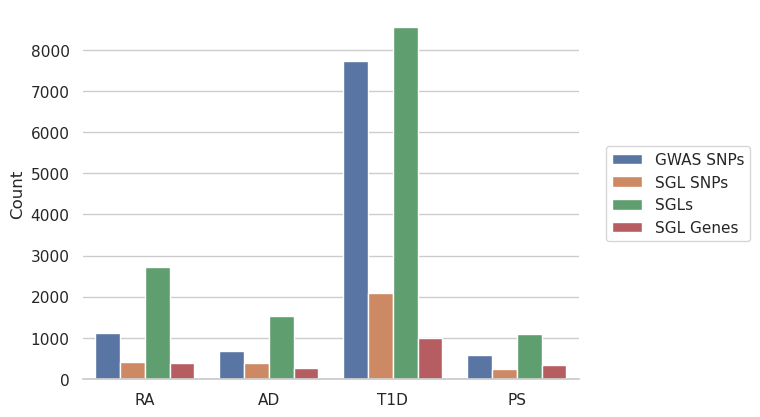

In [16]:
# extract data
plot_data = combine_uniq_mesh_counts.melt(ignore_index=False).reset_index()
plot_data.replace({'num_total_snps': 'GWAS SNPs', 'num_snps': 'SGL SNPs',
                    'num_genes': 'SGL Genes', 'num_sgls': 'SGLs',
                    'Arthritis, Rheumatoid': 'RA', 'Dermatitis, Atopic': 'AD',
                    'Diabetes Mellitus, Type 1': 'T1D', 'Psoriasis': 'PS'}, inplace=True)

# plot data
fig, ax = plt.subplots()

sns.barplot(plot_data, x='mesh_term', y='value', hue='variable', ax=ax)

# remove left spine
sns.despine(left=True)

# move legend
sns.move_legend(ax, "upper center", bbox_to_anchor=(1.2, 0.65))

# rotate X-Axis Ticks by 45-degrees
#ax.tick_params(axis='x', labelrotation = 75)

# set labels
ax.set_xlabel('')
ax.set_ylabel('Count')
legend = ax.legend_
legend.set_title('') 

outfn = os.path.join(outdir, 'sgl_breakdowns.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

We can see that Type 1 Diabetes has the most number of SGLs. 

In [17]:
mesh_grps = all_df.groupby(['mesh_term'])

In [18]:
def get_top_counts(df, n=10):
    sorted_df = df.genename.value_counts().iloc[0:n]
    return(sorted_df)
mesh_grps.apply(get_top_counts)

mesh_term                  genename    
Arthritis, Rheumatoid      BRPF3            430
                           Z84485.1         430
                           FLOT1            364
                           IER3-AS1         364
                           IER3             364
                           HIST1H4A         273
                           HIST1H3A         273
                           ARID5B           239
                           HIST1H2BJ        230
                           HIST1H2AG        230
Dermatitis, Atopic         TRIB1            438
                           NFKBIA           333
                           MIR6090          302
                           AC009812.1       273
                           ZBTB10           273
                           RPL41            196
                           ESYT1            196
                           AC034102.7       196
                           ZC3H10           196
                           AL662844.4       167


If we get the top SGLs based on genes we can see that gene such as NFKBIA are coming up.

In [205]:
cols = ['chrA_loop', 'startA_loop', 'endA_loop',
         'chrB_loop', 'startB_loop', 'endB_loop',
         '-log10_qval_loop', 'sample',
         'end_snp', 'snp_anchor', 
         'genename', 'geneid', 
         'mesh_term', 'author', 'causaldb_fn']

new_cols = ['ChrA', 'StartA', 'EndA',
             'ChrB', 'StartB', 'EndB',
             '-log10(Q values)', 'Sample Name',
             'SNP Pos', 'SNP Anchor', 
             'Gene Name', 'Gene ID', 
             'Mesh Term', 'Author', 'CAUSALdb Study ID']

mesh_outfn = os.path.join(outdir, 'sgls.supplemental_table.xlsx')
with pd.ExcelWriter(mesh_outfn) as fw:
    for grp, grp_df in mesh_grps:
        tdf = grp_df[cols].sort_values(['author', 'sample', 'chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'end_snp', 'geneid'])
        tdf.loc[:, 'chrA_loop'] = 'chr' + tdf.loc[:, 'chrA_loop'].astype(str)
        tdf.loc[:, 'chrB_loop'] = 'chr' + tdf.loc[:, 'chrB_loop'].astype(str)
        tdf.columns = new_cols
        tdf.to_excel(fw, sheet_name=grp[0], index=False)

In [203]:
outfn

'results/hg38/finemapping/sgls_summary/t1d_sgls.genes_per_snp.png'

In [204]:
tdf

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,sample,end_snp,snp_anchor,genename,geneid,causaldb_fn,mesh_term,author,filename
14318,chr1,33125000,33130000,chr1,33180000,33185000,16.981496,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,33125272,AnchorA,TRIM62,ENSG00000116525,AT258,Psoriasis,Roslin Institute,AT258
14321,chr1,33125000,33130000,chr1,33180000,33185000,16.981496,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,33126162,AnchorA,TRIM62,ENSG00000116525,AT258,Psoriasis,Roslin Institute,AT258
14319,chr1,33125000,33130000,chr1,33180000,33185000,16.981496,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,33126447,AnchorA,TRIM62,ENSG00000116525,AT258,Psoriasis,Roslin Institute,AT258
14320,chr1,33125000,33130000,chr1,33180000,33185000,16.981496,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,33127286,AnchorA,TRIM62,ENSG00000116525,AT258,Psoriasis,Roslin Institute,AT258
14347,chr2,60880000,60885000,chr2,61535000,61540000,6.362967,CD4_Naive_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,60881694,AnchorA,XPO1,ENSG00000082898,AT258,Psoriasis,Roslin Institute,AT258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33319,chr16,31035000,31040000,chr16,31070000,31075000,24.294590,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,31038702,AnchorA,ZNF646,ENSG00000167395,GD09415,Psoriasis,Tsoi LC,GD09415
33320,chr16,31035000,31040000,chr16,31070000,31075000,24.294590,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,31038712,AnchorA,ZNF668,ENSG00000167394,GD09415,Psoriasis,Tsoi LC,GD09415
33321,chr16,31035000,31040000,chr16,31070000,31075000,24.294590,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,31038712,AnchorA,ZNF646,ENSG00000167395,GD09415,Psoriasis,Tsoi LC,GD09415
33322,chr16,31040000,31045000,chr16,31070000,31075000,6.898227,THP-1-del-cIDR.GSE149420.Homo_Sapiens.H3K27ac.b1,31043286,AnchorA,ZNF668,ENSG00000167394,GD09415,Psoriasis,Tsoi LC,GD09415


## Diving into SGLs for T1D

In [19]:
t1d_df = mesh_grps.get_group('Diabetes Mellitus, Type 1')

In [20]:
t1d_df.geneid.nunique()

990

In [21]:
sgl_viz_cols = ['chr_snp', 'end_snp',
                'genename', 'geneid', 'start_gene', 'end_gene',
                'startA_loop', 'startB_loop', '-log10_qval_loop',
                'sample', 'author']
t1d_df.sort_values(['-log10_qval_loop', 'chr_snp', 'end_snp'], ascending=[False, True, True])[sgl_viz_cols].head(10)

,chr_snp,end_snp,genename,geneid,start_gene,end_gene,startA_loop,startB_loop,-log10_qval_loop,sample,author
86150,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
86151,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
83597,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
83598,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
85059,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V
85060,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V
82363,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,THP-1-Vector-Batch1.GSE149420.Homo_Sapiens.H3K...,Forgetta V
82364,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,THP-1-Vector-Batch1.GSE149420.Homo_Sapiens.H3K...,Forgetta V
84584,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,388.777188,THP-1-del-cIDR-Batch2.GSE149420.Homo_Sapiens.H...,Forgetta V
84585,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,388.777188,THP-1-del-cIDR-Batch2.GSE149420.Homo_Sapiens.H...,Forgetta V


In [22]:
t1d_uniq_sgls = t1d_df.drop_duplicates(['chrA_loop', 'chrB_loop', 'startA_loop', 'startB_loop', 'geneid', 'start_snp'])

### Count and plot the number of sgls and snps per gene

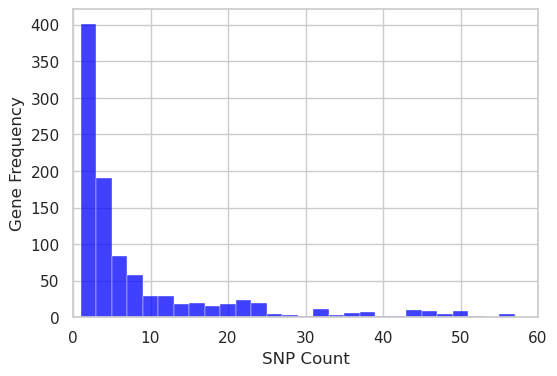

In [23]:
# getting the data
snps_per_gene = t1d_uniq_sgls.groupby('geneid').snp_pos.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.histplot(snps_per_gene['snp_pos'], color='blue', binwidth=2, ax=ax)

ax.set_xlim(0, 60)
ax.set_xlabel('SNP Count')
ax.set_ylabel('Gene Frequency')
ax.set_title('')

outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')


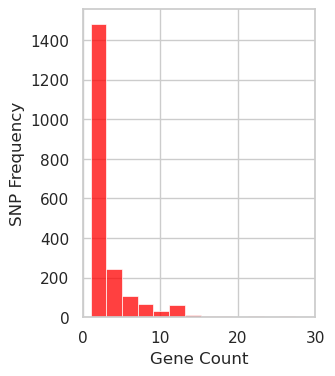

In [24]:
# getting the data
genes_per_snp = t1d_uniq_sgls.groupby('snp_pos').geneid.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(3,4))
sns.set_theme(style="whitegrid")
sns.histplot(genes_per_snp['geneid'], color='red', binwidth=2, ax=ax)

ax.set_xlim(0, 30)
ax.set_xlabel('Gene Count')
ax.set_ylabel('SNP Frequency')

outfn = os.path.join(outdir, 't1d_sgls.genes_per_snp.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

In [25]:
genes_per_snp.head()

,snp_pos,geneid
0,6:26021644,66
1,6:26157534,61
2,6:26157851,61
3,6:27865396,59
4,6:27869489,59


### Compare to the Consensus Gene List

In [26]:
def print_genelist(genelist):
    print('\n'.join(list(genelist)))

#### Save a list of unique genes for T1D

In [27]:
# get the uniq T1D SGL genes
uniq_genes = t1d_df.genename.unique()
print('The unique number of genes is: {}'.format(len(uniq_genes)))

The unique number of genes is: 985


In [28]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(uniq_genes))
    fw.write(s)

#### Load the consensus T1D gene list

In [29]:
t1d_consensus_list_fn = '/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/projects/dchallenge/results/main/gene_lists/consensus_gene_list.txt'
t1d_consensus_genes = pd.read_table(t1d_consensus_list_fn, header=None, names=['genename'])
print('The number of consensus genes is: {}'.format(t1d_consensus_genes.shape[0]))

The number of consensus genes is: 497


#### Overlap the SGL genes with the consensus genes 

In [30]:
t1d_plus_consensus_df = t1d_df.loc[t1d_df.genename.isin(t1d_consensus_genes.iloc[:, 0].tolist())]

In [31]:
shared_t1d_plus_consensus_genes = sorted(t1d_plus_consensus_df.genename.unique().tolist())
print('The unique number of genes is: {}'.format(len(shared_t1d_plus_consensus_genes)))

The unique number of genes is: 85


In [32]:
all_t1d_genes = set(t1d_df.genename.tolist())

In [33]:
only_t1d_genes = all_t1d_genes.difference(shared_t1d_plus_consensus_genes)

In [34]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'left_venn_only.uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(only_t1d_genes))
    fw.write(s)

## Investigating Shared Genes

In [175]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get shared genes for T1D
shared_gene_df = base_genes_df.loc[base_genes_df.genename.isin(shared_t1d_plus_consensus_genes)]

# set associated sgls
shared_gene_sgls = t1d_df.loc[all_df.geneid.isin(shared_gene_df.geneid.tolist())]

# testing the removal of hist proteins
shared_gene_sgls = shared_gene_sgls.loc[~shared_gene_sgls.genename.str.contains('HIST')]

# add distance 
shared_gene_sgls.loc[:, 'distance'] = shared_gene_sgls.loc[:, 'startB_loop'] - shared_gene_sgls.loc[:, 'startA_loop']

In [176]:
shared_gene_sgls

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chr_snp,start_snp,end_snp,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,causaldb_fn,sample,mesh_term,author,filename,snp_pos,distance
8864,10,6050000,6055000,10,6085000,6090000,20.522821,10,6054703,6054704,AnchorA,10,6089033,6089034,RBM17,ENSG00000134453,+,GD09657,Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Inshaw JRJ,GD09657,10:6054704,35000
8865,12,111405000,111410000,12,111425000,111430000,12.928116,12,111427244,111427245,AnchorB,12,111405947,111405948,SH2B3,ENSG00000111252,+,GD09657,Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Inshaw JRJ,GD09657,12:111427245,20000
8866,12,111405000,111410000,12,111445000,111450000,9.802462,12,111446803,111446804,AnchorB,12,111405947,111405948,SH2B3,ENSG00000111252,+,GD09657,Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Inshaw JRJ,GD09657,12:111446804,40000
8881,17,39750000,39755000,17,39860000,39865000,26.196889,17,39754114,39754115,AnchorA,17,39864311,39864312,IKZF3,ENSG00000161405,-,GD09657,Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Inshaw JRJ,GD09657,17:39754115,110000
8882,17,39750000,39755000,17,39860000,39865000,26.196889,17,39752613,39752614,AnchorA,17,39864311,39864312,IKZF3,ENSG00000161405,-,GD09657,Naive_B_1800-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Inshaw JRJ,GD09657,17:39752614,110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94763,22,37195000,37200000,22,37240000,37245000,7.386890,22,37195249,37195250,AnchorA,22,37244447,37244448,RAC2,ENSG00000128340,-,GD09063,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Robertson CC,GD09063,22:37195250,45000
94764,22,37195000,37200000,22,37240000,37245000,7.386890,22,37196065,37196066,AnchorA,22,37244447,37244448,RAC2,ENSG00000128340,-,GD09063,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Robertson CC,GD09063,22:37196066,45000
94765,6,32435000,32440000,6,32665000,32670000,27.778130,6,32669978,32669979,AnchorB,6,32439877,32439878,HLA-DRA,ENSG00000204287,+,GD09063,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Robertson CC,GD09063,6:32669979,230000
94766,6,32435000,32440000,6,32710000,32715000,7.349138,6,32712344,32712345,AnchorB,6,32439877,32439878,HLA-DRA,ENSG00000204287,+,GD09063,Naive_B_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Robertson CC,GD09063,6:32712345,275000


In [178]:
# calculating genes which are present in SGLs across more than 3 samples
shared_gene_freqs = shared_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
shared_genes_high_freq = shared_gene_freqs[shared_gene_freqs > 3]
shared_genes_high_freq_list = shared_genes_high_freq.index.tolist()

In [180]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = []
candidates = shared_gene_sgls.loc[shared_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(shared_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


,genename,geneid,strand,causaldb_fn,sample,mesh_term,author,filename,snp_pos,distance
82108,RAD51B,ENSG00000182185,+,GD09519,Natural_Killer_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815616,1000000
82110,RAD51B,ENSG00000182185,+,GD09519,Natural_Killer_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815994,1000000
82756,RAD51B,ENSG00000182185,+,GD09519,CD8_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815616,1000000
82758,RAD51B,ENSG00000182185,+,GD09519,CD8_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815994,1000000
82924,RAD51B,ENSG00000182185,+,GD09519,CD8_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815616,1000000
82926,RAD51B,ENSG00000182185,+,GD09519,CD8_Naive_1816-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815994,1000000
83129,RAD51B,ENSG00000182185,+,GD09519,CD4_Naive_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815616,1000000
83131,RAD51B,ENSG00000182185,+,GD09519,CD4_Naive_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815994,1000000
83793,RAD51B,ENSG00000182185,+,GD09519,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815616,1000000
83795,RAD51B,ENSG00000182185,+,GD09519,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,14:68815994,1000000


In [182]:
candidates.genename.unique()

array(['RAD51B', 'ATXN2L', 'CCRL2', 'NCOA1', 'CCR5'], dtype=object)

## Investigate Novel Genes

In [35]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get novel genes for T1D
novel_gene_df = base_genes_df.loc[base_genes_df.genename.isin(only_t1d_genes)]

# set associated sgls
novel_gene_sgls = t1d_df.loc[all_df.geneid.isin(novel_gene_df.geneid.tolist())]

# testing the removal of hist proteins
novel_gene_sgls = novel_gene_sgls.loc[~novel_gene_sgls.genename.str.contains('HIST')]

# add distance 
novel_gene_sgls.loc[:, 'distance'] = novel_gene_sgls.loc[:, 'startB_loop'] - novel_gene_sgls.loc[:, 'startA_loop']

,chrom,start,end,strand,geneid,genename,genetype
57044,chr1,34712737,34859755,-,ENSG00000163866,SMIM12,protein_coding
57602,chr1,35176378,35193145,-,ENSG00000116560,SFPQ,protein_coding
57696,chr1,35268967,35422058,+,ENSG00000146463,ZMYM4,protein_coding
57854,chr1,35433492,35557950,-,ENSG00000142687,KIAA0319L,protein_coding
58152,chr1,35557473,35567274,+,ENSG00000020129,NCDN,protein_coding
...,...,...,...,...,...,...,...
2649601,chr22,36860988,36878017,+,ENSG00000100365,NCF4,protein_coding
2649952,chr22,37010859,37020183,-,ENSG00000128311,TST,protein_coding
2649994,chr22,37019635,37029822,+,ENSG00000128309,MPST,protein_coding
2650080,chr22,37051736,37063390,+,ENSG00000100379,KCTD17,protein_coding


In [49]:
#print(','.join(list(novel_gene_sgls.geneid.unique())))

In [39]:
# counting snp-gene pairs 
novel_gene_sgls.loc[:, 'sgname'] = novel_gene_sgls.loc[:, 'genename'] + ' & ' + novel_gene_sgls.loc[:, 'snp_pos']
sgpair_counts = novel_gene_sgls.sgname.value_counts().to_frame()

I'm interested in the frequency of each SNP + gene pair. Hopefully there is a pair with lots of samples. 

In [40]:
sgl_freqs = sgpair_counts.sort_index()['count'].unique()
sgl_freqs

array([ 11,   1,   2,   4,   9,   3,  21,   6,  25,  10,  13,  30,  12,
        70,  28,  16,   8,  15,   5,  14,  40,  20,  46,  42,  63,  39,
       156,   7,  32,  18,  22,  24,  31,  17,  26,  45,  29,  33,  23,
        41,  69,  27,  48, 125,  50,  55,  84,  54,  60,  37,  85,  34,
        36,  35,  90,  75,  78, 234, 120,  44,  72,  19])

In [48]:
pd.options.display.max_rows = None
display(sgpair_counts)
pd.options.display.max_rows = 200


,count
sgname,
SGF29 & 16:28494339,234
APOBR & 16:28554837,156
AC138894.1 & 16:28554837,156
APOBR & 16:28554346,156
AC138894.1 & 16:28554346,156
ZC3H10 & 12:56041628,125
ESYT1 & 12:56041628,125
RPL41 & 12:56041628,125
STARD3 & 17:39754115,120


In [131]:
# calculating genes which are present in SGLs across more than 3 samples
novel_gene_freqs = novel_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
novel_genes_high_freq = novel_gene_freqs[novel_gene_freqs > 3]
novel_genes_high_freq_list = novel_genes_high_freq.index.tolist()

In [170]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = ['CD63', 'AC009779.2', 'AC073896.2', 'AC145285.3', 'SETD9', 'PUM3', 'AC022506.1', 'DDIT3', 'MBD6', 'PKNOX1', 'GPBP1']
check_genes += ['SLC30A1', 'ZBTB37', 'EIF1', 'CENPL', 'DARS2', 'ZFYVE26', 'KMT2E', 'NIPBL', 'BRIX1', 'RAD1', 'LONRF1']
check_genes += ['RAPGEF6', 'ITGB1', 'FAM210A', 'RNMT', 'DTL', 'INTS7', 'SIMM12', 'EPC1', 'SMIM12', 'NUDT6']
check_genes += ['RFX3', 'SPATA5', 'DUSP28', 'HSPA4', 'ZIC2', 'ANKMY1', 'RNPEPL1', 'ZSCAN22', 'FKBP1B']
check_genes += ['WDCP', 'SFPQ', 'CYP20A1', 'DOCK9', 'NCK1', 'FANCI', 'RRP1', 'STK40', 'AFG3L2']
check_genes += ['STAG1', 'NEK7', 'UBE2G2', 'RO60', 'DNAJC27', 'TNFSF4', 'ABHD2', 'IFT27', 'GDF9', 'UQCRQ']
check_genes += ['PRKAR1A', 'WIPI1', 'NCF4', 'TRAPPC10', 'PTRHD1', 'HAPLN3', 'HEXIM2', 'KIF14', 'UBAC2']
check_genes += ['GDF11', 'STARD3', 'SECISBP2', 'RARA', 'CCR1', 'CCR2', 'ORMDL2', 'SENP3', 'SENP3-EIF4A1']
candidates = novel_gene_sgls.loc[novel_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(novel_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

#display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


In [171]:
for x in candidates.genename.unique():
    print(x)

APIP
PDHX
DTYMK
ING5
C17orf49
RNASEK
RNASEK-C17orf49
CENPO
HOXA7
MFGE8
AC009163.4
SPEF2
HOXA1
PSMD3
CKS2
SARNP
TRIB2
MTERF4
FAM53B
FMNL1


In [117]:
nck1 = candidates.loc[candidates.genename == 'NCK1']
nck1

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chr_snp,start_snp,end_snp,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,causaldb_fn,sample,mesh_term,author,filename,snp_pos,sgname,distance
83310,3,136250000,136255000,3,136860000,136865000,8.139618,3,136254605,136254606,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136254606,NCK1 & 3:136254606,610000
83312,3,136250000,136255000,3,136860000,136865000,8.139618,3,136250752,136250753,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1815-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136250753,NCK1 & 3:136250753,610000
85688,3,136250000,136255000,3,136860000,136865000,7.231814,3,136254605,136254606,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136254606,NCK1 & 3:136254606,610000
85690,3,136250000,136255000,3,136860000,136865000,7.231814,3,136250752,136250753,AnchorA,3,136862207,136862208,NCK1,ENSG00000158092,+,GD09519,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b2,"Diabetes Mellitus, Type 1",Forgetta V,GD09519,3:136250753,NCK1 & 3:136250753,610000


Unfortunately there are not. Initially I was trying to find an example where a SGL is found across many samples but this is just not found in the data. So I started to think, what else can I find or what other point can I make? For now, the point that I will try making is that we found a good SNP (or gene) which is found across many samples. 

I'll start with a good SNP, if I find one. 

In [45]:
snp_counts = novel_gene_sgls.drop_duplicates(subset=['sample', 'snp_pos']) # want unique sample + snps
snp_counts = snp_counts.groupby(by=['snp_pos']).count()['chrA_loop'] # counting the unique number of snps per sample 
snp_counts = snp_counts.reset_index().rename(columns={'chrA_loop': 'count'}).sort_values(['count'], ascending=[True, False]) # cleaning + sorting
snp_counts = snp_counts.pivot(index='snp_pos', columns='sample_grp', values='count', ) # pivoting for side-by-side analysis of grps
snp_counts = snp_counts.fillna(0) # remove NaN's
snp_counts = snp_counts.astype(int) # convert to ints
snp_counts.loc[:, 'sum'] = snp_counts.iloc[:, 0:6].sum(axis=1) # add row sum
snp_counts.loc[:, 'max'] = snp_counts.iloc[:, 0:6].max(axis=1) # add row max

# add the mb location
def get_mb(x):
    spl = x.split(':')
    res = spl[0] + ':' + spl[1][0:2]
    return(res)
snp_counts['chr_mb'] = [get_mb(x)for x in snp_counts.index.values]

# filter based on the max
snp_counts_flt = snp_counts.loc[snp_counts['max'] > 2].sort_values(['chr_mb', 'max'], ascending=[True, False])

snp_counts_flt = snp_counts_flt.reset_index().set_index(['chr_mb', 'snp_pos']) # creating multi-index with chr_mb

ValueError: Length of ascending (2) != length of by (1)

In [ ]:

# highlight based on the max
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_gte_thresh = data > 3
        return [attr if v else '' for v in is_gte_thresh]
    else:  # from .apply(axis=None)
        is_gte_thresh = data > 3
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

snp_counts_flt.style.apply(highlight_max, subset=['max'])

In [ ]:
novel_gene_sgls.loc[(novel_gene_sgls.snp_pos.str.contains('^11:64'))]['genename']

#### Deeper dive into specific cases

In [116]:
novel_geneA = 'ZNF487'
novel_gene_df = t1d_df.loc[t1d_df.genename == novel_geneA]
novel_gene_df

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chr_snp,start_snp,end_snp,...,genename,geneid,strand,causaldb_fn,sample,sample_grp,mesh_term,author,filename,snp_pos


In [117]:
t = novel_gene_sgls.drop_duplicates(['geneid', 'sample'])

In [118]:
t.value_counts(subset=['genename', 'geneid']).head(20)

genename    geneid         
AC116366.3  ENSG00000283782    43
CHRAC1      ENSG00000104472    43
TRAPPC9     ENSG00000167632    42
AC138894.1  ENSG00000261832    42
APOBR       ENSG00000184730    42
TAPBP       ENSG00000231925    40
STARD3      ENSG00000131748    40
UBAC2       ENSG00000134882    40
SGF29       ENSG00000176476    39
AL031777.3  ENSG00000282988    38
MSL2        ENSG00000174579    37
SEH1L       ENSG00000085415    36
ZC3H10      ENSG00000135482    32
ESYT1       ENSG00000139641    32
RPL41       ENSG00000229117    32
NPAT        ENSG00000149308    31
ZNF165      ENSG00000197279    31
ATM         ENSG00000149311    31
PSMD3       ENSG00000108344    31
RGL2        ENSG00000237441    30
Name: count, dtype: int64